# Modifying FastPitch to Train on a Non-English (German) Dataset

This notebook is designed to provide a guide on how to train FastPitch on a German dataset from scratch as part of the TTS pipeline. It contains the following sections:
  1. **Introduction**: FastPitch and HiFi-GAN in NeMo
  2. **Dataset Preparation**: How to prepare German dataset for FastPitch
  3. **Training**: Example of FastPitch training and evaluation
  4. **Finetuning HiFi-GAN**: Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from FastPitch

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [ ]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'tts_germanfastpitch'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget unidecode pynini==2.1.4 scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

In [ ]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
# lets download the files we need to run this tutorial

!mkdir /NeMo
!cd /NeMo && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/openslr/get_data.py
!cd /NeMo && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch.py
!cd /NeMo && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py
!cd /NeMo && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/extract_sup_data.py
!cd /NeMo && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/de/fastpitch_align_22050.yaml
!cd /NeMo && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml
!cd /NeMo && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/de/data/whitelist.tsv

# Introduction

### FastPitch

FastPitch is non-autoregressive model for mel-spectrogram generation based on FastSpeech, conditioned on fundamental frequency contours. For more details about model, please refer to the original [paper](https://ieeexplore.ieee.org/abstract/document/9413889). Original [FastPitch model](https://ieeexplore.ieee.org/abstract/document/9413889) uses an external Tacotron 2 model trained on LJSpeech-1.1 to extract training alignments and estimate durations of input symbols. This implementation of FastPitch is based on [Deep Learning Examples](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/FastPitch), which uses an alignment mechanism proposed in [RAD-TTS](https://openreview.net/pdf?id=0NQwnnwAORi) and extended in [TTS Aligner](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9747707).

For more information on training a basic FastPitch model, please refer to [FastPitch_MixerTTS_Training.ipynb](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_MixerTTS_Training.ipynb) tutorial.

### HiFiGAN
HiFiGAN is a generative adversarial network (GAN) model that generates audio from mel spectrograms. The generator uses transposed convolutions to upsample mel spectrograms to audio. For more details about the model, please refer to the original [paper](https://arxiv.org/abs/2010.05646). NeMo re-implementation of HiFi-GAN can be found [here](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/tts/models/hifigan.py).

# Dataset Preparation

We will show example of preprocessing and training using OpenSLR's German Neutral TTS dataset ([link](https://www.openslr.org/95)). It is a free single german speaker dataset (> 23 hours) by Thorsten Müller (voice) and Dominik Kreutz (audio optimization) for tts training. 

In this section, we will cover:
1. Downloading the dataset
2. Creating manifests
3. Normalizing text
4. Phonemization
5. Creating dataset config
6. Creating suppplementary data

## 1. Downloading the dataset

In [ ]:
!mkdir /Data && \
    cd /Data && \
    wget https://us.openslr.org/resources/95/thorsten-de_v02.tgz && \
    tar -zxvf thorsten-de_v02.tgz

In [ ]:
# /Data directory looks like
!ls /Data -R


```bash
$ ls /Data -R
/Data:
thorsten-de  thorsten-de_v02.tgz

/Data/thorsten-de:
metadata.csv  metadata_shuf.csv  metadata_train.csv  metadata_val.csv  wavs

/Data/thorsten-de/wavs:
00025a6fbea659dae6ece011e749aa34.wav  80689a91d5c8e32847ccbba2322e2122.wav
000314280388fb390b3e70b69ee53a23.wav  8068cbcbe28085c15d2e8a8f7291d009.wav
000624f768d7e282534a850980619fb2.wav  8071b84557c9a780d23414e241393f00.wav
000c5b9d181c934e8a343fb561c928bd.wav  8073badcfce74546b2bab83f76dbf043.wav
001364406f288f03136403c611fff1dc.wav  80743e8e580d128673e181cc15b47cc9.wav
...
```

## 2. Creating manifests 

We've created `scripts/dataset_processing/tts/openslr/get_data.py` script that reads the `/Data/thorsten-de/metadata.csv` provided with the dataset and generates the following fields per each datapoint:
1. `audio_filepath`: location of the wav file
2. `duration`: duration of the wav file
3. `text`: original text supplied by OpenSLR
    
After that, the script randomly splits the datapoints into 3 buckets, `train_manifest.json`, `val_manifest.json` and `test_manifest.json`. Example:

In [ ]:
!(cd /NeMo && \
    python get_data.py \
        --data-root /Data/ \
        --val-size 0.1 \
        --test-size 0.2)

In the example above, 10% datapoints go to validation set, 20% go to test set and the remaining 70% go to training set.

In [ ]:
# /Data directory looks like
!ls /Data -R

```bash
$ ls /Data -R
/Data:
thorsten-de
thorsten-de_v02.tgz

/Data/thorsten-de:
metadata.csv
metadata_shuf.csv
metadata_train.csv
metadata_val.csv
test_manifest.json
train_manifest.json
val_manifest.json
wavs

/Data/thorsten-de/wavs:
00025a6fbea659dae6ece011e749aa34.wav
000314280388fb390b3e70b69ee53a23.wav
000624f768d7e282534a850980619fb2.wav
...
```

## 3. Normalizing text

The script above, i.e. `scripts/dataset_processing/tts/openslr/get_data.py`, also generates a another field per each datapoint:
- `normalized_text`: normalized text via NeMo's text normalizer:
    ```python
    nemo_text_processing.text_normalization.normalize.Normalizer(lang="de", input_case="cased", overwrite_cache=True, cache_dir=str(file_path / "cache_dir"))
    ```
    
German language text normalizer (defined here: `nemo_text_processing/text_normalization/de`) was created using the tutorial shared under NeMo's `Grammar customization` documentation [here](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/nlp/text_normalization/wfst/wfst_text_normalization.html#grammar-customization). Here are some example records:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/f1becc89cb4079a123ead68c9c8bb8ae.wav", "duration": 7.250023, "text": "Öffne den Webbrowser und rufe www.archlinux.org auf.", "normalized_text": "Öffne den Webbrowser und rufe w w w punkt a r c h l i n u x punkt o r g auf."}
```
Notice that the URL has been spelled out. 

In other cases, the normalized text may look the same as text, example:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?"}
```

## 4. Phonemization

The pronunciation of a word can be represented as a string of phones, which are speech sounds, each represented with symbols adapated from the Roman alphabet. The IPA is designed to represent those qualities of speech that are part of lexical (and to a limited extent prosodic) sounds in oral language: phones, phonemes, intonation and the separation of words and syllables. Training model with phonemes as well as text will help the model generate more accurate speech sounds.

In [ ]:
print("text: Geht die Schandtat auf sein Konto?")
print("phoneme: \u0261e\u02d0t di\u02d0 \u0283ant\u0251\u02d0t a\u028af za\u026an k\u0254nto\u02d0")

The original dataset only contains text input, so, in order to add phonemes, we need to convert German text into phonemes using [bootphon/phonemizer](https://github.com/bootphon/phonemizer).

One of the easiest ways to install phonemizer is via pip and espeak backend via apt:

In [ ]:
!pip install phonemizer && apt-get install espeak-ng

Alternatively, you can use phonemizer via docker container:
```bash
git clone https://github.com/bootphon/phonemizer
cd phonemizer
docker build -t phonemizer .
docker run --rm -d -it -p 8888:8888 -v /Data:/Data --ipc=host phonemizer /bin/bash
docker exec -it <docker_container_id> /bin/bash
```

Other install methods for phonemizer are listed [here](https://bootphon.github.io/phonemizer/install.html).

In [ ]:
from phonemizer.backend import EspeakBackend
import json

backend = EspeakBackend('de')

input_manifest_filepaths = ["/Data/thorsten-de/train_manifest", "/Data/thorsten-de/test_manifest", "/Data/thorsten-de/val_manifest"]

for input_manifest_filepath in input_manifest_filepaths:
    output_manifest_filepath = input_manifest_filepath+"_phonemes"
    records = []
    n_text = []
    with open(input_manifest_filepath + ".json", "r") as f:
        for i, line in enumerate(f):
            d = json.loads(line)
            records.append(d)
            n_text.append(d['normalized_text'])

    phonemized = backend.phonemize(n_text)

    new_records = []
    for i in range(len(records)):
        records[i]["is_phoneme"] = 0
        new_records.append(records[i])
        phoneme_record = records[i].copy()
        phoneme_record["normalized_text"] = phonemized[i]
        phoneme_record["is_phoneme"] = 1
        new_records.append(phoneme_record)

    with open(output_manifest_filepath + ".json", "w") as f:
        for r in new_records:
            f.write(json.dumps(r) + '\n')

To better understand the phonemize method, refer to the docs [here](https://github.com/bootphon/phonemizer/blob/master/phonemizer/backend/base.py#L137).

Run the above script for train, test and val records, resulting in `train_phonemes_manifest.json`, `test_phonemes_manifest.json` and `val_phonemes_manifest.json` respectively.

We are effectively doubling the size of our dataset. Each original record maps on to two records, one with original `normalized_text` field value and `is_phoneme` set to 0 and another with phonemized text and `is_phoneme` flag set to 1.

Example of input record:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?"}
```
And corresponding output records:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "is_phoneme": 0}
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "\u0261e\u02d0t di\u02d0 \u0283ant\u0251\u02d0t a\u028af za\u026an k\u0254nto\u02d0 ", "is_phoneme": 1}
```

## 5. Creating dataset config

Most of the configuration remains the same as described in [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) except:
1. The `text_tokenizer._target_` is set to `nemo.collections.tts.torch.tts_tokenizers.GermanCharsTokenizer` class defined here: `collections/tts/torch/tts_tokenizers.py`, and pass `is_phoneme: true`, which will extend the `de_alphabet` to include IPA symbols, resulting in `abcdefghijklmnopqrstuvwxyzäöüßʊʃŋɜːɛɾəɪçɔøɡœɑÜ„1Q̃ɒʒÄɹÖʌθàó̈ðéɐá`. 

2. The `text_normalizer.lang` is set to `de`, in order to use the tokenizer defined in `nemo_text_processing/text_normalization/de` (as discussed above).

3. Update the `whitelist_path` to point to German whitelist: `nemo_text_processing/text_normalization/de/data/whitelist.tsv`

Final config looks like:

```yaml
name: "ds_for_fastpitch_align"

manifest_filepath: "train_manifest.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]
whitelist_path: "/NeMo/whitelist.tsv"

dataset:
  _target_: nemo.collections.tts.torch.data.TTSDataset
  manifest_filepath: ${manifest_filepath}
  sample_rate: 22050
  sup_data_path: ${sup_data_path}
  sup_data_types: ${sup_data_types}
  n_fft: 1024
  win_length: 1024
  hop_length: 256
  window: "hann"
  n_mels: 80
  lowfreq: 0
  highfreq: 8000
  max_duration: null
  min_duration: 0.1
  ignore_file: null
  trim: false
  pitch_fmin: 65.40639132514966
  pitch_fmax: 2093.004522404789

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: de
    input_case: cased
    whitelist: ${whitelist_path}

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.tts.torch.tts_tokenizers.GermanCharsTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true
    phonemes: true
```

Save the above config in `/NeMo/ds_for_fastpitch_align.yaml`.

## 6. Creating Supplementary Data

As mentioned in the [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) - To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time, via `extract_sup_data.py` script.

Note: This is an optional step, if skipped, it will be automatically executed within the first epoch of training FastPitch.

In [ ]:
!cd /NeMo/ && \
    python extract_sup_data.py \
        --config-path /NeMo \
        --config-name ds_for_fastpitch_align.yaml \
        manifest_filepath=/Data/thorsten-de/train_manifest_phonemes.json \
        sup_data_path=/Data/thorsten-de/phonemes/

The above example gives the following result:
1. Creates two folders under `sup_data_path` - `pitch` and `align_prior_matrix`
2. Prints out `PITCH_MEAN, PITCH_STD = 132.524658203125, 37.389366149902344`

# Training

Before we train our model, let's define model config. Most of the model config stays the same as defined here: `examples/tts/conf/fastpitch_align_44100.yaml`, except:
1. Make the same changes that we made in dataset config for `text_tokenizer`, `text_normalizer` and `whitelist_path`.

2. The `pitch_mean` and `pitch_std` are updated to the values reported by the `extract_sup_data.py` script.

3. The `sample_rate` is updated to 22050 KHz per our dataset. And accordingly halve the `n_window_size`, `n_window_stride` and `n_fft` parameters as well. 

We have already downloaded the config after making these changes here: `/NeMo/fastpitch_align_22050.yaml`

In [ ]:
!cat /NeMo/fastpitch_align_22050.yaml

If you are using Weights and Biases, you may need to login first. More details [here](https://docs.wandb.ai/ref/cli/wandb-login).

In [ ]:
wandb_api_key = "apikey"
wandb_project_name = "GermanTTS"
wandb_run_name = "tutorial"

!wandb login ${wandb_api_key}

Now we are ready for training our model! Let's try to train FastPitch.

In [ ]:
!(cd /NeMo && CUDA_VISIBLE_DEVICES=0 python fastpitch.py --config-path /NeMo --config-name fastpitch_align_22050 \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=32 \
    train_dataset=/Data/thorsten-de/train_manifest_phonemes.json \
    validation_datasets=/Data/thorsten-de/val_manifest_phonemes.json \
    sup_data_path=/Data/thorsten-de/phonemes/ \
    whitelist_path=/NeMo/whitelist.tsv \
    exp_manager.exp_dir=/result \
    trainer.max_epochs=1 \
    pitch_mean=132.524658203125 \
    pitch_std=37.389366149902344 \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name=${wandb_run_name} \
    +exp_manager.wandb_logger_kwargs.project=${wandb_project_name})

Note:
1. We use `CUDA_VISIBLE_DEVICES=0` to limit training to single GPU.
2. For debugging you may also add the following flags: `HYDRA_FULL_ERROR=1`, `CUDA_LAUNCH_BLOCKING=1`

<b>Note</b>: We've limited the above run to 1 epoch only, so we can validate the implementation within the scope of this tutorial. We recommend around 1000 epochs when training FastPitch from scratch.

## Evaluating FastPitch + pretrained HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model pre-trained on English.

In [ ]:
hfg_ngc = "tts_hifigan" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_hifigan 
fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>" # from the results directory
test = "Diese Musiksammlung soll die Vielfalt des Lebens widerspiegeln." # text input to the model
test_id = "877d9f668a877713b48735f282af62ca" # identifier for the audio corresponding to the test text
data_path = "/Data/thorsten-de/wavs/" # path to dataset folder with wav files from original dataset

In [ ]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [ ]:
# load models
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

In [ ]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

We see that audio quality is not as good as we expect. One of the ways mentioned in the [FastPitch_Finetuning.ipynb](FastPitch_Finetuning.ipynb) tutorial is to finetune HiFi-GAN. Lets try that out next!

# Finetuning HiFi-GAN

Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from FastPitch. 

## Generating synthetic mels

To generate mel-spectrograms from FastPitch, we can use `generate_spectrogram` method defined in `nemo/collections/tts/models/fastpitch.py`. However, the resulting spectrogram may be different from ground truth mel spectrogram, as shown below:

In [7]:
test_audio_filepath = "/Data/thorsten-de/wavs/5d000c81c8e7c4817cbfd7c4b8738feb.wav"
test_audio_text = "Dieser Geruch, wenn jemand eine Clementine \u00f6ffnet!"
fastpitch_model_path = "<path_to_fastpitch_nemo>"

In [12]:
from matplotlib.pyplot import imshow
from nemo.collections.tts.models import FastPitchModel
from matplotlib import pyplot as plt
import librosa
import librosa.display
import torch
import soundfile as sf
import numpy as np
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()

def plot_logspec(spec, axis=None):    
    librosa.display.specshow(
        librosa.amplitude_to_db(spec, ref=np.max),
        y_axis='linear', 
        x_axis="time",
        fmin=0, 
        fmax=8000,
        ax=axis
    )

In [ ]:
spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()

So we have 2 types of mel spectrograms that we can use for finetuning HiFi-GAN:

### 1. Original mel spectrogram generated from original audio file

loading original melspec
spectrogram shape =  (80, 315)


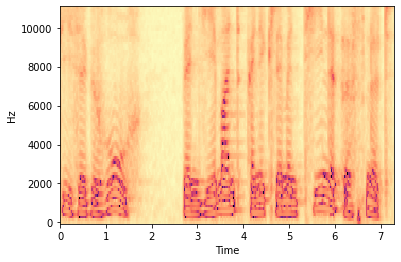

In [15]:
print("loading original melspec")
y, sr = librosa.load(test_audio_filepath)
# change n_fft, win_length, hop_length parameters below based on your specific config file
spectrogram2 = np.log(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, win_length=1024, hop_length=256))
spectrogram = spectrogram2[ :80, :]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

### 2. Mel spectrogram predicted from FastPitch

loading fastpitch melspec via generate_spectrogram
spectrogram shape =  (80, 291)


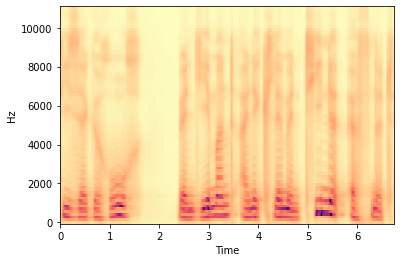

In [17]:
print("loading fastpitch melspec via generate_spectrogram")
with torch.no_grad():
    text = spec_model.parse(test_audio_text, normalize=False)
    spectrogram = spec_model.generate_spectrogram(
      tokens=text, 
      speaker=None,
    )
spectrogram = spectrogram.to('cpu').numpy()[0]
plot_logspec(spectrogram)
print("spectrogram shape = ", spectrogram.shape)
plt.show()

<b>Note</b>: The above spectrogram has the duration 291 which is not equal to the ground truth length, i.e. 315. In order to finetune HiFi-GAN we need mel spectrogram predicted from FastPitch with groundtruth alignment and duration.

### 2.1 Mel spectrogram predicted from FastPitch with groundtruth alignment and duration 

loading fastpitch melspec via forward method with groundtruth alignment and duration
spectrogram shape =  (80, 315)


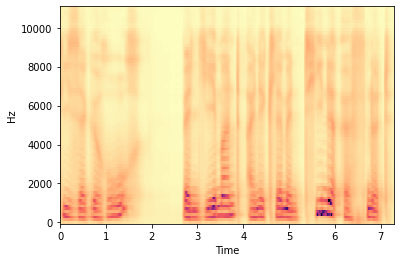

In [20]:
print("loading fastpitch melspec via forward method with groundtruth alignment and duration")
with torch.no_grad():
    device = spec_model.device
    beta_binomial_interpolator = BetaBinomialInterpolator()
    text = spec_model.parse(test_audio_text, normalize=False)
    text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    audio = load_wav(test_audio_filepath)
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    attn_prior = torch.from_numpy(
      beta_binomial_interpolator(spect_len.item(), text_len.item())
    ).unsqueeze(0).to(text.device)
    spectrogram = spec_model.forward(
      text=text, 
      input_lens=text_len, 
      spec=spect, 
      mel_lens=spect_len, 
      attn_prior=attn_prior,
      speaker=None,
    )[0]
spectrogram = spectrogram.to('cpu').numpy()[0]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

In our experience, 
- Finetuning with #1 has artifacts from the original audio (noise) that get passed on as input to the vocoder resulting in artifacts in vocoder output in the form of noise.
- <b> On the other hand, #2.1 (i.e. `Mel spectrogram predicted from FastPitch with groundtruth alignment and duration`) gives the best results because it enables HiFi-GAN to learn mel spectrograms generated by FastPitch as well as duration distributions closer to the real world (i.e. ground truth) durations. </b>

From implementation perspective - we follow the same process described in [Finetuning FastPitch for a new speaker](FastPitch_Finetuning.ipynb) - i.e. take the latest checkpoint from FastPitch training and predict spectrograms for each of the input records in `train_manifest_phonemes.json`, `test_manifest_phonemes.json` and `val_manifest_phonemes.json`.

In [ ]:
import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "synmels"
fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>"
dataset_part = "test_phonemes" # or "val_phonemes", "train_phonemes"
dataset_base_path = "/Data/"

from nemo.collections.tts.models import FastPitchModel
if ".nemo" in fastpitch_model_path:
    spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
# Get records from the manifest
manifest_path = dataset_base_path+"thorsten-de/"+dataset_part+"_manifest.json"
records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        records.append(json.loads(line))

beta_binomial_interpolator = BetaBinomialInterpolator()

spec_model.eval()
device = spec_model.device

save_dir = Path(dataset_base_path+folder_name+"/"+dataset_part)

save_dir.mkdir(exist_ok=True, parents=True)

# Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
for i, r in enumerate(records):
    audio = load_wav(r["audio_filepath"])

    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

    # Again, our finetuned FastPitch model doesn't use multiple speakers,
    # but we keep the code to support it here for reference
    if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
        speaker = torch.tensor([r['speaker']]).to(device)
    else:
        speaker = None

    with torch.no_grad():
        if "normalized_text" in r:
            text = spec_model.parse(r["normalized_text"], normalize=False)
        else:
            text = spec_model.parse(r['text'])

        text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

        spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

        # Generate attention prior and spectrogram inputs for HiFi-GAN
        attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
        
        spectrogram = spec_model.forward(
              text=text, 
              input_lens=text_len, 
              spec=spect, 
              mel_lens=spect_len, 
              attn_prior=attn_prior,
              speaker=speaker,
            )[0]

    save_path = save_dir / f"mel_{i}.npy"
    np.save(save_path, spectrogram[0].to('cpu').numpy())
    r["mel_filepath"] = str(save_path)

hifigan_manifest_path = dataset_base_path+folder_name+"/hifigan_"+dataset_part+"_ft.json"

with open(hifigan_manifest_path, "w") as f:
    for r in records:
        f.write(json.dumps(r) + '\n')

Revisiting how we implement #2.1 (i.e. Predicted mel spectrogram predicted from FastPitch with groundtruth alignment and duration):

1. Notice above that we use audio from dataset (`audio` variable) to compute spectrogram length (`spect_len`):
    ```python
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    ```
2. and groundtruth alignment (`attn_prior`).
    ```python
    attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
    ```
3. We use both of them to generate synthetic mel spectrogram via `spec_model.forward` method:
    ```python
    spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
    ```
    
Repeat the above script for train and validation datasets as well. 

Finally, the `/Data/synmels` will look like:
```
/Data/synmels/:
hifigan_test_ft.json
hifigan_train_ft.json
hifigan_val_ft.json
test
train
val

/Data/synmels/test:
mel_0.npy
mel_1.npy
...

/Data/synmels/train:
mel_0.npy
mel_1.npy
...

/Data/synmels/val:
mel_0.npy
mel_1.npy
...
```

Example HiFi-GAN manifest:
```json
{"audio_filepath": "/Data/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "mel_filepath": "/Data/synmels/test/mel_0.npy"}
```

## Launch finetuning

Download the pre-trained HiFi-GAN from NGC.

In [ ]:
!(cd /Data && \
  wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/zip -O tts_hifigan_1.0.0rc1.zip && \
  unzip tts_hifigan_1.0.0rc1.zip)

Setting up wandb

In [ ]:
wandb_project_name = "GermanTTS"
wandb_run_name = "tutorial_2"

We will be re-using the existing HiFi-GAN config and HiFi-GAN pretrained on English.

In [ ]:
!(cd /NeMo && \
  python hifigan_finetune.py --config-path /NeMo --config-name hifigan.yaml \
    model.max_steps=10 \
    model.optim.lr=0.00001 \
    model.train_ds=train_ds_finetune \
    model.validation_ds=val_ds_finetune \
    ~model.optim.sched \
    train_dataset=/Data/synmels/hifigan_train_phonemes_ft.json \
    validation_datasets=/Data/synmels/hifigan_val_phonemes_ft.json \
    exp_manager.exp_dir=/result \
    +init_from_nemo_model=/Data/tts_hifigan.nemo \
    trainer.devices=-1 \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name=${wandb_run_name} \
    exp_manager.wandb_logger_kwargs.project=${wandb_project_name})

<b>Note</b>: We've limited the above run to 10 steps only, so we can validate the implementation within the scope of this tutorial. We recommend evaluating around every 50 steps HiFi-GAN until you get desired quality results.

## Evaluating FastPitch and Finetuned HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model finetuned on predicted mels.

In [ ]:
hfg_path = "<path_to_finetuned_hifigan_nemo_or_ckpt>"

if ".nemo" in hfg_path:
    vocoder_model_pt = HifiGanModel.restore_from(hfg_path).eval().cuda()
else:
    vocoder_model_pt = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval().cuda()

In [ ]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model_pt, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

That's it!